In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from tqdm.auto import tqdm, trange
import xgboost as xgb
import joblib
from sklearn.model_selection import cross_validate
import zipfile

from src.model import tscv, ClippedOutputRegressor
from src.data import get_feature_cols, df_to_X_y, drop_non_features, add_lagged_features


%run constants.py

baseline_reg = joblib.load(os.path.join(MODELS_DIR, 'xgb-baseline.model'))

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.1
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2


We got the release date for our dataset, now let's try and capture info on the items/shops that were discontinued by building a `last seen` feature. Just like the release date, this will be a delta instead of the actual date.

In [17]:
sales_train = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'sales-train.parquet'))
train_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set.parquet'))

In [18]:
    samples = sales_train[['item_id', 'shop_id', 'date_block_num']].drop_duplicates()

In [19]:
df = samples.copy()
groups = [['item_id'],
          ['item_id', 'shop_id'],
          ['shop_id']]

In [20]:
for group in tqdm(groups):
    group_id = '_'.join(group) 
    date_col = '%s_last_seen_date' % group_id
    delta_col = '%s_since_last_seen' % group_id
    months_dfs = []
    for month in trange(1, 35):
        month_df = sales_train[sales_train['date_block_num'] < month].groupby(group)['date_block_num'].max().reset_index()
        month_df.rename(columns={'date_block_num': date_col}, inplace=True)
        month_df['date_block_num'] = month
        months_dfs.append(month_df)
    grp_df = pd.concat(months_dfs, axis=0)
    df = df.merge(grp_df, on=group + ['date_block_num'], how='left')
    df[delta_col] = df['date_block_num'] - df[date_col]
df.fillna(-999, inplace=True)

In [21]:
df.describe()

,item_id,shop_id,date_block_num,item_id_last_seen_date,item_id_since_last_seen,item_id_shop_id_last_seen_date,item_id_shop_id_since_last_seen,shop_id_last_seen_date,shop_id_since_last_seen
count,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06
mean,1.068099e+04,3.280586e+01,1.466480e+01,-9.430966e+01,-1.060496e+02,-2.531549e+02,-2.615883e+02,-3.103444e+01,-4.373374e+01
std,6.238884e+03,1.653701e+01,9.542325e+00,3.134756e+02,3.092886e+02,4.462722e+02,4.411665e+02,2.096808e+02,2.067384e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02
25%,5.045000e+03,2.100000e+01,6.000000e+00,4.000000e+00,1.000000e+00,-9.990000e+02,-9.990000e+02,5.000000e+00,1.000000e+00
50%,1.049700e+04,3.100000e+01,1.400000e+01,1.200000e+01,1.000000e+00,8.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
75%,1.606000e+04,4.700000e+01,2.300000e+01,2.100000e+01,1.000000e+00,1.800000e+01,2.000000e+00,2.200000e+01,1.000000e+00
max,2.216900e+04,5.900000e+01,3.300000e+01,3.200000e+01,3.300000e+01,3.200000e+01,3.300000e+01,3.200000e+01,1.200000e+01


<AxesSubplot:xlabel='item_id_since_last_seen'>

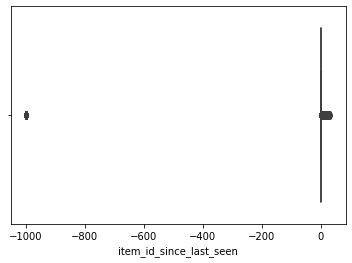

In [22]:
sns.boxplot(df['item_id_since_last_seen'])

<AxesSubplot:xlabel='item_id_since_last_seen'>

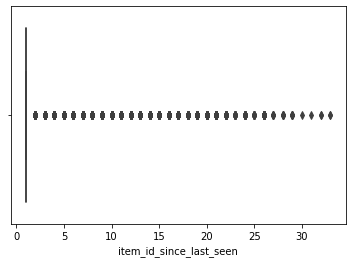

In [24]:
sns.boxplot(df[df['item_id_since_last_seen'] > -999]['item_id_since_last_seen'])